In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu")(inputs)
x2 = layers.Dense(64, activation="relu")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

Metal device set to: Apple M1 Pro


2022-07-18 12:17:26.061583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 12:17:26.062034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

# Custom training loop from scratch

In [6]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))


Start of epoch 0
Training loss (for one batch) at step 0: 176.5758
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5660
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.2464
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.8647
Seen so far: 38464 samples

Start of epoch 1
Training loss (for one batch) at step 0: 1.0121
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.7193
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.8347
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4905
Seen so far: 38464 samples


# Low-level handling of metrics

In [9]:
# Get model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [10]:
import time

epochs = 2
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                f"Training loss (for one batch) at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {(step + 1) * batch_size} samples")
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {float(train_acc):.4f}")
    
    # Reset training metrics at the end of each epoch.
    train_acc_metric.reset_states()
    
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print(f"Validation acc: {float(val_acc):.4f}")
    print(f"Time take: {(time.time() - start_time):.2f}s")


Start of epoch 0
Training loss (for one batch) at step 0: 95.2496
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5882
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.3027
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.0033
Seen so far: 38464 samples
Training acc over epoch: 0.5643
Validation acc: 0.6910
Time take: 5.85s

Start of epoch 1
Training loss (for one batch) at step 0: 1.0066
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.3606
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.5636
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.7878
Seen so far: 38464 samples
Training acc over epoch: 0.7157
Validation acc: 0.7316
Time take: 5.85s


# Speeding-up training step with tf.function

Describing computation as a static graph enables the framework to apply global performance optimization.

In [11]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

In [12]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [13]:
import time

epochs = 2
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss_value = train_step(x_batch_train, y_batch_train)
        
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                f"Training loss (for one batch) at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {(step + 1) * batch_size} samples")
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {float(train_acc):.4f}")
    
    # Reset training metrics at the end of each epoch.
    train_acc_metric.reset_states()
    
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print(f"Validation acc: {float(val_acc):.4f}")
    print(f"Time take: {(time.time() - start_time):.2f}s")


Start of epoch 0
Training loss (for one batch) at step 0: 0.9499
Seen so far: 64 samples


2022-07-18 12:35:38.171698: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 12:35:38.174620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training loss (for one batch) at step 200: 0.9130
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.7557
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.1162
Seen so far: 38464 samples


2022-07-18 12:35:40.367657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 12:35:40.428797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training acc over epoch: 0.7657


2022-07-18 12:35:40.738326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation acc: 0.8103
Time take: 2.70s

Start of epoch 1
Training loss (for one batch) at step 0: 0.5610
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.5576
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.5320
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4344
Seen so far: 38464 samples
Training acc over epoch: 0.8062
Validation acc: 0.8250
Time take: 2.35s


# Low-level handling of losses tracked by the model

In [14]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs

In [15]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu")(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        # Add any extra losses created during the forward pass.
        loss_value += sum(model.losses)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

# End-to-end example: a GAN training loop from scratch

In [39]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 128)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                     

In [40]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [41]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

In [42]:
import os

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 20  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))


Start epoch 0


2022-07-18 13:20:00.991269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


discriminator loss at step 0: 0.70
adversarial loss at step 0: 0.72
discriminator loss at step 200: 0.02
adversarial loss at step 200: 4.91
discriminator loss at step 400: 0.56
adversarial loss at step 400: 1.08
discriminator loss at step 600: 0.54
adversarial loss at step 600: 1.09
discriminator loss at step 800: 0.63
adversarial loss at step 800: 0.84
discriminator loss at step 1000: 0.42
adversarial loss at step 1000: 1.47


2022-07-18 13:21:07.036605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Start epoch 1
discriminator loss at step 0: 0.41
adversarial loss at step 0: 1.59
discriminator loss at step 200: 0.52
adversarial loss at step 200: 1.28
discriminator loss at step 400: 0.25
adversarial loss at step 400: 2.04
discriminator loss at step 600: 0.27
adversarial loss at step 600: 1.97
discriminator loss at step 800: 0.75
adversarial loss at step 800: 0.84
discriminator loss at step 1000: 0.65
adversarial loss at step 1000: 0.86

Start epoch 2
discriminator loss at step 0: 0.68
adversarial loss at step 0: 0.94
discriminator loss at step 200: 0.63
adversarial loss at step 200: 0.95
discriminator loss at step 400: 0.68
adversarial loss at step 400: 0.81
discriminator loss at step 600: 0.63
adversarial loss at step 600: 0.77
discriminator loss at step 800: 0.64
adversarial loss at step 800: 0.80
discriminator loss at step 1000: 0.67
adversarial loss at step 1000: 0.82

Start epoch 3
discriminator loss at step 0: 0.69
adversarial loss at step 0: 0.84
discriminator loss at step 

discriminator loss at step 600: 0.63
adversarial loss at step 600: 1.09
discriminator loss at step 800: 0.62
adversarial loss at step 800: 1.09
discriminator loss at step 1000: 0.54
adversarial loss at step 1000: 1.09


In [43]:
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
predictions = generator.predict(random_latent_vectors)
predictions.shape

2/2 [==============================] - 0s 8ms/step


2022-07-18 15:01:51.884018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(64, 28, 28, 1)

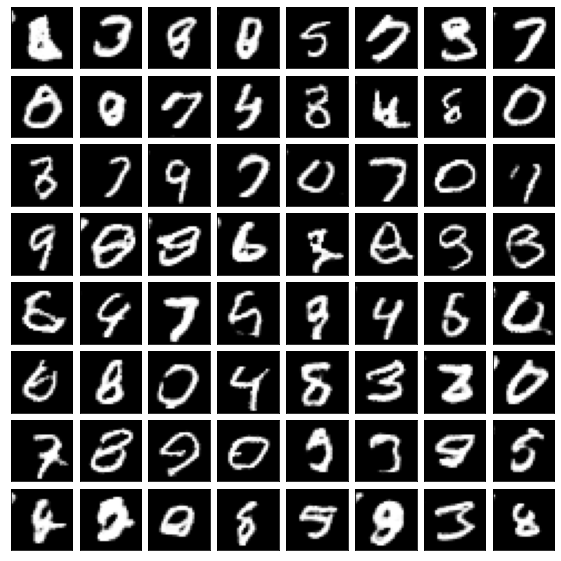

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [pred for pred in predictions]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])